# Timeline QA LoRA Finetuning of Flan T5 base and large

### Saved model

The finetuned model is saved on hugging face in the following model repo:
- <b>Ana091202/flan_t5_base_timeline_qa
- - <b>Ana091202/flan_t5_timeline_qa (for the large model)

### Instructions to finetune a new model
- Make a new model repo in hugging face
- Change the hub_name and the model name

### Flan T5 models

  <img src="https://images.datacamp.com/image/upload/v1699032555/image8_241fd08d9c.png" alt="Learning" width="50%">

  For our research we choose to finetune the following variants of Flan-T5:
  - google/flan-t5-base
  - google/flan-t5-large

### Finetuning with LoRa (Low Rank Adaptation)


  Unlike conventional fine-tuning methods where all weights are updated from all layers (leading to high computational cost - note: this method was tried but due to the high waiting time for the training loop we decided to change to LoRa), LoRA strategically freezes pre-trained model weights and introduces trainable rank decomposition matrices into the Transformer architecture's layers making the training process faster and possible on smaller GPUs. This significantly reduces the number of trainable parameters, leading to expedited fine-tuning processes and mitigated overfitting.

### Text2Text Generation

  Text-to-Text Generation, also known as Sequence-to-Sequence Modeling, is the process of converting one piece of text into another. It is commonly used in tasks such as language translation, summarization, and question-answering, so this can be used for our timeline QA task.


### PeftModel

  Note:
  1. <b>`PeftModel.from_pretrained`:</b>
     - By default, the adapter of the PEFT model is frozen (non-trainable).
     - You can change this by adjusting the `is_trainable` configuration.

  2. <b>`get_peft_model` function:</b>
     - Parameters are not frozen by default.
     - Result: you obtain a trainable PEFT model for the SFT task.

  3. <b>Fine-tuning an already fine-tuned PEFT model:</b>
     - Utilize `from_pretrained`.
     - Set `is_trainable = True` to enable training of the previously fine-tuned model.

### Evaluation - ROUGE score

  ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is usually used to evaluate the quality of QA. This will not necessary check the correctness of the timeline answer performance, but when evaluating the initial finetuned model is it good to start with this. Other evaluation metrics will be introduced when benchmarking the models.
  - ROUGE-L: Measures the longest common subsequence between the candidate and reference answers. This focuses on recall of the full text.
  - ROUGE-1, ROUGE-2, ROUGE-SU4: Compare unigram, bigram, 4-gram overlaps between candidate and reference. Focus on recall of key parts/chunks

  Note: Scores close to or above 0.70+ are considered strong.
  When using this metric, processing like stemming, and removing stopwords can help improve the overall performance.

### Training procedure

Since, T5 is a text-to-text model, the labels of the dataset are converted as follows: For each example, a sentence as been formed as "Question sentence: " + Answer sentence.

Note: training loop is done manually without relying on the Trainer module.

Credits: https://github.com/YanSte/NLP-LLM-Fine-tuning-QA-LoRA-T5/blob/main/nlp-llm-fine-tuning-lora-t5-l.ipynb


### Setup

In [ ]:
%%capture
!pip install -U torch torchvision evaluate transformers datasets accelerate peft deepspeed rouge-score

In [ ]:
import torch
assert torch.cuda.is_available()

In [ ]:
import os
import gc
import json
import platform
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv

import torch
from torch.utils.data import DataLoader


from huggingface_hub import login

from datasets import Dataset, DatasetDict, load_dataset
import datasets

from transformers import pipeline, T5ForConditionalGeneration, AutoTokenizer, AutoConfig, default_data_collator, get_linear_schedule_with_warmup, DataCollatorForSeq2Seq, set_seed
import transformers

from peft import LoraConfig, TaskType, get_peft_model, get_peft_model_state_dict, PeftModel
from peft.utils.other import fsdp_auto_wrap_policy
from peft import PeftConfig

from accelerate import Accelerator

import evaluate
import nltk

#### Config

In [ ]:

cache_dir = "./cache"
seed = 42

hub_repo = "Ana091202/flan_t5_timeline_qa"

model_name_or_path = "google/flan-t5-large"

# Data formatting - prefix for our task
prefix = "Answer the following question: "

# Data formatting and tokenization
tokenizer_input_max_tokens = 256
tokenizer_output_max_tokens = 256
tokenizer_num_proc=16

data_loader_batch_size = 4

# Lora
lora_task_type=TaskType.SEQ_2_SEQ_LM
lora_inference_mode=False
lora_r=8
lora_alpha=32
lora_dropout=0.1

# Model
lr = 1e-4
num_epochs = 3

def get_peft_model_name_or_path(model_name_or_path, peft_config):
    return f"{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}".replace("/", "_")

def get_optimizer(model, lr):
    return torch.optim.AdamW(model.parameters(), lr=lr)


# Pipeline
pipeline_task = "text2text-generation"
pipeline_min_length=20
pipeline_temperature=0.3
pipeline_max_length=256

In [ ]:
# in order to load the model to hugging face we need the personal token
# This is also need when loading the model
# Uncomment if you are using Google Colab
# from google.colab import userdata
#
# login(token=userdata.get('HF_TOKEN'))
load_dotenv()  # Load variables from the .env file
secret_token = os.getenv("HF_TOKEN")
login(token=secret_token)

#### Setup

In [ ]:
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [ ]:
set_seed(seed)

Accelerator

In [ ]:
accelerator = Accelerator()

Log

In [ ]:
datasets.utils.logging.set_verbosity_error()
transformers.utils.logging.set_verbosity_error()

Rouge metric

In [ ]:
# Download NLTK punkt tokenizer
nltk.download("punkt", quiet=True)

# Load ROUGE metric
rouge_metric = evaluate.load("rouge")

#### Methods

In [ ]:
def accelerator_print_sep(accelerator=accelerator):
    sep = "#" * 12
    accelerator.print(sep)

def clear_gpu_memory():
    """Clear GPU memory by emptying the cache and collecting garbage."""
    torch.cuda.empty_cache()
    gc.collect()

def print_system_specs():
    # Check if CUDA is available
    is_cuda_available = torch.cuda.is_available()
    print("CUDA Available:", is_cuda_available)
# Get the number of available CUDA devices
    num_cuda_devices = torch.cuda.device_count()
    print("Number of CUDA devices:", num_cuda_devices)
    if is_cuda_available:
        for i in range(num_cuda_devices):
            # Get CUDA device properties
            device = torch.device('cuda', i)
            print(f"--- CUDA Device {i} ---")
            print("Name:", torch.cuda.get_device_name(i))
            print("Compute Capability:", torch.cuda.get_device_capability(i))
            print("Total Memory:", torch.cuda.get_device_properties(i).total_memory, "bytes")
    # Get CPU information
    print("--- CPU Information ---")
    print("Processor:", platform.processor())
    print("System:", platform.system(), platform.release())
    print("Python Version:", platform.python_version())

#### Specs

In [ ]:
print_system_specs()

CUDA Available: True
Number of CUDA devices: 1
--- CUDA Device 0 ---
Name: Tesla T4
Compute Capability: (7, 5)
Total Memory: 15835660288 bytes
--- CPU Information ---
Processor: x86_64
System: Linux 6.1.85+
Python Version: 3.10.12


# <b>Fine-Tuning</b>


In [ ]:
# Load train and val datasets
with open('train_TLQA.json', 'r') as f:
    training_data = json.load(f)

with open('val_TLQA.json', 'r') as f:
    validation_data = json.load(f)

def prepare_dataset(data):
    questions, answers = [], []
    for item in data:
        question = item['question']
        answer = '; '.join(item['final_answers'])
        questions.append(question)
        answers.append(answer)
    return {"question": questions, "answer": answers}

train_dataset_dict = prepare_dataset(training_data)
train_dataset = Dataset.from_dict(train_dataset_dict)

val_dataset_dict = prepare_dataset(validation_data)
valid_dataset = Dataset.from_dict(val_dataset_dict)

# Create a new DataFrame
df = pd.DataFrame()
df["question"] = train_dataset_dict["question"]
df["answer"] = train_dataset_dict["answer"]

# Save to CSV file
df.to_csv("./train.csv", index=False)

In [ ]:
df.head()

,question,answer
0,"List all entities that owned Radisson Hotel Group, also known as Radisson Hospitality, Inc., from 2010 to 2020.","Carlson (2010, 2011, 2012, 2013, 2014, 2015, 2016); HNA Group (2016, 2017, 2018); Jinjiang International (2018, 2019, 2020)"
1,List all educational institutions Jón Axel Guðmundsson attended from 2014 to 2020.,"Church Farm School (2014, 2015); Davidson College (2016, 2017, 2018, 2019, 2020)"
2,List all positions Sajid Javid held from 2015 to 2020.,"Secretary of State for Business and Trade (2015, 2016); Secretary of State for Levelling Up, Housing and Communities (2016, 2017, 2018); Home Secretary (2018, 2019); Chancellor of the Exchequer (2019, 2020)"
3,"List all political parties Cristian Preda, also known as Cristian Dan Preda, was a member of from 2010 to 2020.","Democratic Liberal Party (2010, 2011, 2012, 2013, 2014); People's Movement Party (2014); independent politician (2014, 2015, 2016, 2017, 2018); Liberty, Unity and Solidarity Party (2019, 2020)"
4,"List all coaches of Hibernian F.C., also known as Hibernian Football Club, from 2011 to 2020","Pat Fenlon (2011, 2012, 2013); Jack Ross (2019, 2020); Paul Heckingbottom (2019)"


In [ ]:
train_dataset

Dataset({
    features: ['question', 'answer'],
    num_rows: 3212
})

In [ ]:
pd.DataFrame(train_dataset[:15]).head(15)

,question,answer
0,"List all entities that owned Radisson Hotel Group, also known as Radisson Hospitality, Inc., from 2010 to 2020.","Carlson (2010, 2011, 2012, 2013, 2014, 2015, 2016); HNA Group (2016, 2017, 2018); Jinjiang International (2018, 2019, 2020)"
1,List all educational institutions Jón Axel Guðmundsson attended from 2014 to 2020.,"Church Farm School (2014, 2015); Davidson College (2016, 2017, 2018, 2019, 2020)"
2,List all positions Sajid Javid held from 2015 to 2020.,"Secretary of State for Business and Trade (2015, 2016); Secretary of State for Levelling Up, Housing and Communities (2016, 2017, 2018); Home Secretary (2018, 2019); Chancellor of the Exchequer (2019, 2020)"
3,"List all political parties Cristian Preda, also known as Cristian Dan Preda, was a member of from 2010 to 2020.","Democratic Liberal Party (2010, 2011, 2012, 2013, 2014); People's Movement Party (2014); independent politician (2014, 2015, 2016, 2017, 2018); Liberty, Unity and Solidarity Party (2019, 2020)"
4,"List all coaches of Hibernian F.C., also known as Hibernian Football Club, from 2011 to 2020","Pat Fenlon (2011, 2012, 2013); Jack Ross (2019, 2020); Paul Heckingbottom (2019)"
5,List all educational institutions Kylie Moore-Gilbert attended from 2010 to 2017.,"University of Cambridge (2010, 2011, 2012, 2013); Wolfson College (2010, 2011, 2012, 2013); University of Melbourne (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017)"
6,"List all entities that owned Wind River Systems, also known as Wind River Systems Inc., from 2010 to 2020.","Intel (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018); TPG (2018, 2019, 2020)"
7,"List all political parties Kanatbek Isaev, also known as Kanatbek Isaew, was a member of from 2010 to 2020.","Respublika (2010, 2011, 2012, 2013, 2014, 2015); Kyrgyzstan Party (2015, 2016, 2017, 2018, 2019, 2020)"
8,List all educational institutions Sonja Kovač attended from 2010 to 2020.,"Faculty of Law of the University of Zagreb (2010, 2011, 2012); New York Film Academy (2015, 2016, 2017, 2018, 2019, 2020)"
9,List all heads of the government of Heilongjiang from 2013 to 2020,"Lu Hao (2013, 2014, 2015, 2016, 2017, 2018); Wang Wentao (2018, 2019, 2020)"


Once the data is acquired, it is split into training and testing datasets, respectively, at the proportion of 70% and 30%, and this is achieved using the train_test_split function.

In [ ]:
valid_dataset

Dataset({
    features: ['question', 'answer'],
    num_rows: 1428
})

In [ ]:
pd.DataFrame(valid_dataset[:15]).head(15)

,question,answer
0,"List all chairpersons of Christian Democratic and Flemish, also known as CD&V, from 2010 to 2020","Wouter Beke (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019); Joachim Coens (2019, 2020)"
1,"List all employers Valerie Ashby, also known as Valerie Sheares Ashby, worked for from 2010 to 2020.","University of North Carolina at Chapel Hill (2010, 2011, 2012, 2013, 2014, 2015); Duke University (2015, 2016, 2017, 2018, 2019, 2020)"
2,"List all sports teams Evan Horwood, also known as Evan David Horwood, played for from 2010 to 2016.","Hartlepool United F.C. (2010, 2011, 2012, 2013); Carlisle United F.C. (2010); Tranmere Rovers F.C. (2013, 2014); Northampton Town F.C. (2014); Grimsby Town F.C. (2016)"
3,"List all political parties Antoni Comín, also known as Toni Comín, was a member of from 2011 to 2020.","Socialists' Party of Catalonia (2011, 2012, 2013, 2014); Junts per Catalunya (2020)"
4,"List all positions Pope Francis, also known as Jorge Mario Bergoglio, held from 2010 to 2020.","cardinal (2010, 2011, 2012, 2013); pope (2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)"
5,List all heads of the government of Malang City from 2013 to 2020,"Muhammad Anton (2013, 2014, 2015, 2016, 2017, 2018); Sutiaji (2018, 2019, 2020)"
6,List all political parties Peter Pilz was a member of from 2010 to 2020.,"The Greens – The Green Alternative (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017); NOW – Pilz List (2017, 2018, 2019, 2020)"
7,"List all heads of the government of Valencia, also known as València, from 2010 to 2020","Rita Barberá Nolla (2010, 2011, 2012, 2013, 2014, 2015); Joan Ribó (2015, 2016, 2017, 2018, 2019, 2020)"
8,"List all sports teams Etrit Berisha, also known as Etrit Fadil Berisha, played for from 2010 to 2020.","Kalmar FF (2010, 2011, 2012, 2013); Albania national association football team (2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020); S.S. Lazio (2013, 2014, 2015, 2016, 2017); Atalanta BC (2016, 2017, 2018, 2019, 2020); Società Polisportiva Ars et Labor (2019, 2020)"
9,List all sports teams Philipp Lahm played for from 2010 to 2017.,"Germany national association football team (2010, 2011, 2012, 2013, 2014); FC Bayern Munich (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017)"


### Model and Tokenizer initialization


In [ ]:
model = T5ForConditionalGeneration.from_pretrained(model_name_or_path, cache_dir=cache_dir)

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, cache_dir=cache_dir)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

### Data formatting and tokenization



The following prefix is used to format the questions:
```
“Answer the following question: <USER_QUESTION>”
```
We apply tokenization.


In [ ]:
def preprocess_tokenize(examples):
    inputs = [prefix + doc for doc in examples["question"]]

    model_inputs = tokenizer(
        inputs,
        max_length=tokenizer_input_max_tokens,
        padding=True,
        truncation=True
    )

    # Setup the tokenizer for targets
    labels = tokenizer(
        examples["answer"],
        max_length=tokenizer_output_max_tokens,
        padding=True,
        truncation=True
    )

    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

In [ ]:
with accelerator.main_process_first():
    processed_dataset_train = train_dataset.map(
        preprocess_tokenize,
        batched=True,
        num_proc=tokenizer_num_proc,
        remove_columns=train_dataset.column_names,
        load_from_cache_file=False,
        desc="Running tokenizer on dataset",
    )
with accelerator.main_process_first():
    processed_datasets_val = valid_dataset.map(
        preprocess_tokenize,
        batched=True,
        num_proc=tokenizer_num_proc,
        remove_columns=valid_dataset.column_names,
        load_from_cache_file=False,
        desc="Running tokenizer on dataset",
    )


del train_dataset
del valid_dataset

train_dataset = processed_dataset_train
eval_dataset = processed_datasets_val

Running tokenizer on dataset (num_proc=16):   0%|          | 0/3212 [00:00<?, ? examples/s]

Running tokenizer on dataset (num_proc=16):   0%|          | 0/1428 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3212
})

In [ ]:
eval_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1428
})

### DataLoader

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=data_collator,
    batch_size=data_loader_batch_size,
    pin_memory=True
)

eval_dataloader = DataLoader(
    eval_dataset,
    collate_fn=data_collator,
    batch_size=data_loader_batch_size,
    pin_memory=True
)

#### Cleaning Memory

In [ ]:
clear_gpu_memory() # makes sure we don t run out of GPU

### Lora


# `LoraConfig` Class Parameters in `peft` Module

## Parameters

### `r` (int, default=8)
Defines the rank of the low-rank approximation used in LoRA decomposition. A smaller rank reduces computational overhead. Default is 8.

---

### `lora_alpha` (float, default=8)
Scaling factor for LoRA updates. The weight update matrix is scaled by \( \alpha / r \), controlling the learning rate's impact. Default is 8.

---

### `target_modules` (list of str, default=None)
Specifies which model layers to apply LoRA. Use names like "q" (query) and "v" (value) to select layers. If `None`, all layers are targeted.

---

### `lora_dropout` (float, default=0.01)
Dropout rate for LoRA weights to regularize training. Default is 0.01.

---

### `bias` (str, default="none")
Specifies bias behavior:
- `none`: No bias updates.
- `all`: All biases are updated.
- `lora_only`: Only biases in LoRA modules are updated.

---

### `task_type` (str, default="SEQ_2_SEQ_LM")
Defines the task type for fine-tuning. Common values:
- `"SEQ_2_SEQ_LM"`: Sequence-to-Sequence Language Model.
- Others depend on the specific application.

---



In [ ]:
peft_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    task_type=lora_task_type,
    inference_mode=lora_inference_mode
)

In [ ]:
model = get_peft_model(model, peft_config)
accelerator_print_sep()
accelerator.print(model.print_trainable_parameters())
accelerator_print_sep()

############
trainable params: 2,359,296 || all params: 785,509,376 || trainable%: 0.3004
None
############


### Learning Ratescheduler

In [ ]:
# Setup optimizer
optimizer = get_optimizer(model, lr)

In [ ]:
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
if getattr(accelerator.state, "fsdp_plugin", None) is not None:
    accelerator.state.fsdp_plugin.auto_wrap_policy = fsdp_auto_wrap_policy(model)

### Accelerator setup

In [ ]:
model, train_dataloader, eval_dataloader, optimizer, lr_scheduler = accelerator.prepare(
    model,
    train_dataloader,
    eval_dataloader,
    optimizer,
    lr_scheduler
)

### DeepSpeed

DeepSpeed is a library that optimizes training models on distributed architectures, particularly on GPUs.

## `accelerator`
An object that manages hardware acceleration and distributed training, often provided by the Hugging Face Accelerated Inference API or similar frameworks. It abstracts the complexity of using GPUs, TPUs, or multi-node setups for training or inference.

---

## `accelerator.state`
Accesses the internal state of the `accelerator` object. This state contains metadata and configuration details about the current training setup, such as the hardware used, plugins enabled, and the environment setup.

---

## `accelerator.state.deepspeed_plugin`
If DeepSpeed is integrated into the training pipeline, this property provides access to the DeepSpeed plugin object within the accelerator state. The DeepSpeed plugin handles optimizations such as memory efficiency and distributed computation strategies.

---

## `accelerator.state.deepspeed_plugin.zero_stage`
Specifies the current stage of the DeepSpeed ZeRO (Zero Redundancy Optimizer) optimization process. DeepSpeed ZeRO has multiple stages, such as:
- **Stage 1:** Optimizes memory for optimizer states.
- **Stage 2:** Optimizes memory for gradients.
- **Stage 3:** Optimizes memory for parameters by partitioning them across devices.

The `zero_stage` property indicates which level of optimization is currently in use.


In [ ]:
is_ds_zero_3 = False
if getattr(accelerator.state, "deepspeed_plugin", None):
    is_ds_zero_3 = accelerator.state.deepspeed_plugin.zero_stage == 3

### Train

In [ ]:
def train_epoch(model, train_dataloader, optimizer, lr_scheduler, accelerator):
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, disable=not accelerator.is_main_process)):
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    return total_loss / len(train_dataloader)

def evaluate_epoch(model, eval_dataloader, tokenizer, accelerator):
    """
    Evaluate the model on the validation dataset for one epoch.
    """
    model.eval()
    eval_loss = 0
    eval_preds = []

    for step, batch in enumerate(tqdm(eval_dataloader, disable=not accelerator.is_main_process)):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        eval_loss += loss.detach().float()
        preds = accelerator.gather_for_metrics(torch.argmax(outputs.logits, -1)).detach().cpu().numpy()
        eval_preds.extend(tokenizer.batch_decode(preds, skip_special_tokens=True))

    return eval_loss / len(eval_dataloader), eval_preds

def save_model(model, peft_model_name_or_path, accelerator, hub_repo_name):
    """
    Save the model to the specified path.
    """
    accelerator.wait_for_everyone()
    model.save_pretrained(peft_model_name_or_path)
    tokenizer.save_pretrained(peft_model_name_or_path)
    model.push_to_hub(hub_repo_name)
    tokenizer.push_to_hub(hub_repo_name)
    accelerator.wait_for_everyone()

def plot_loss(train_losses, eval_losses):
    """
    Plot training and validation losses.
    """
    plt.figure(figsize=(10, 6))

    # Move tensors to CPU
    train_losses_cpu = [loss.cpu().item() for loss in train_losses]
    eval_losses_cpu = [loss.cpu().item() for loss in eval_losses]

    epochs = range(1, len(train_losses_cpu) + 1)

    plt.plot(epochs, train_losses_cpu, label='Training Loss')
    plt.plot(epochs, eval_losses_cpu, label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
peft_model_name_or_path = get_peft_model_name_or_path(model_name_or_path, peft_config)

train_losses = []
eval_losses = []
rouge_scores = []

# Main training loop
for epoch in range(num_epochs):
    # Train
    accelerator_print_sep()
    accelerator.print(f"Train epoch: {epoch=}")

    train_loss = train_epoch(model, train_dataloader, optimizer, lr_scheduler, accelerator)
    train_ppl = torch.exp(train_loss)

    accelerator_print_sep()
    accelerator.print(f"{epoch=}: {train_ppl=} {train_loss=}")

    train_losses.append(train_loss)

    # Eval
    accelerator_print_sep()
    accelerator.print(f"Eval epoch: {epoch=}")

    eval_loss, eval_preds = evaluate_epoch(model, eval_dataloader, tokenizer, accelerator)
    eval_ppl = torch.exp(eval_loss)

    accelerator_print_sep()
    accelerator.print(f"{epoch=}: {eval_ppl=} {eval_loss=}")

    eval_losses.append(eval_loss)

    # Save
    accelerator_print_sep()
    accelerator.print(f"Save epoch: {epoch=}")
    save_model(model, peft_model_name_or_path, accelerator, hub_repo)

############
Train epoch: epoch=0


100%|██████████| 803/803 [08:10<00:00,  1.64it/s]


############
epoch=0: train_ppl=tensor(102.7909, device='cuda:0') train_loss=tensor(4.6327, device='cuda:0')
############
Eval epoch: epoch=0


100%|██████████| 357/357 [01:16<00:00,  4.66it/s]


############
epoch=0: eval_ppl=tensor(1.8832, device='cuda:0') eval_loss=tensor(0.6330, device='cuda:0')
############
Save epoch: epoch=0


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/9.48M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

############
Train epoch: epoch=1


100%|██████████| 803/803 [08:05<00:00,  1.66it/s]


############
epoch=1: train_ppl=tensor(1.7118, device='cuda:0') train_loss=tensor(0.5375, device='cuda:0')
############
Eval epoch: epoch=1


100%|██████████| 357/357 [01:16<00:00,  4.65it/s]


############
epoch=1: eval_ppl=tensor(1.6541, device='cuda:0') eval_loss=tensor(0.5032, device='cuda:0')
############
Save epoch: epoch=1


adapter_model.safetensors:   0%|          | 0.00/9.48M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


############
Train epoch: epoch=2


100%|██████████| 803/803 [08:09<00:00,  1.64it/s]


############
epoch=2: train_ppl=tensor(1.6676, device='cuda:0') train_loss=tensor(0.5114, device='cuda:0')
############
Eval epoch: epoch=2


100%|██████████| 357/357 [01:16<00:00,  4.65it/s]


############
epoch=2: eval_ppl=tensor(1.6387, device='cuda:0') eval_loss=tensor(0.4939, device='cuda:0')
############
Save epoch: epoch=2


adapter_model.safetensors:   0%|          | 0.00/9.48M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


#### Plot

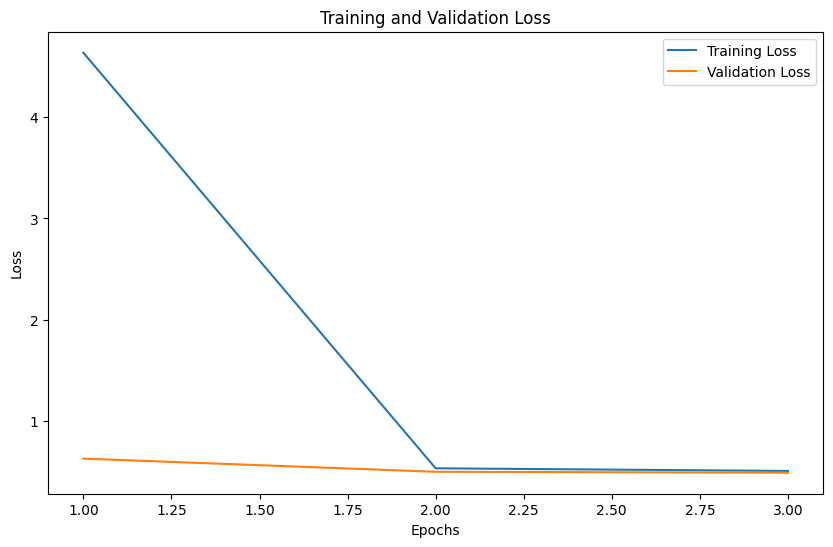

In [ ]:
plot_loss(train_losses, eval_losses)

#### Cleaning Memory

In [ ]:
del model
del train_losses
del eval_losses
del rouge_scores
del lr_scheduler
del optimizer
del peft_config
del train_dataloader
del eval_dataloader
del tokenizer
del data_collator

clear_gpu_memory()

# <b>Performance Evaluation</b>

###Load model and apply Perf

In [ ]:

tokenizer = AutoTokenizer.from_pretrained(hub_repo)
finetuned_model = T5ForConditionalGeneration.from_pretrained(hub_repo)

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/637 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/9.48M [00:00<?, ?B/s]

In [ ]:
finetuned_model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=1024, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=1024, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k): Linear(in_f

### Step 2 - Pipeline

In [ ]:
text_generation_pipeline = pipeline(
    task=pipeline_task,
    model=finetuned_model,
    tokenizer=tokenizer,
    truncation=True,
    max_length=pipeline_max_length,
    min_length=pipeline_min_length,
    temperature=pipeline_temperature,
    device=0 # Set device to 0 for GPU, -1 for CPU
)

### Step 3 - Evaluation

#### Shot Evaluation

In [ ]:
questions = [
    "List all entities that owned Radisson Hotel Group, also known as Radisson Hospitality, Inc., from 2010 to 2020.",
    "List all educational institutions Jón Axel Guðmundsson attended from 2014 to 2020.",
    "List all positions Sajid Javid held from 2015 to 2020.",
    "List all political parties Cristian Preda, also known as Cristian Dan Preda, was a member of from 2010 to 2020.",
    "List all coaches of Hibernian F.C., also known as Hibernian Football Club, from 2011 to 2020.",
    "List all educational institutions Kylie Moore-Gilbert attended from 2010 to 2017.",
    "List all entities that owned Wind River Systems, also known as Wind River Systems Inc., from 2010 to 2020.",
    "List all political parties Kanatbek Isaev, also known as Kanatbek Isaew, was a member of from 2010 to 2020.",
    "List all educational institutions Sonja Kovač attended from 2010 to 2020.",
    "List all heads of the government of Heilongjiang from 2013 to 2020.",
    "List all employers Armen Amiryan, also known as Amiryan, Armen, worked for from 2010 to 2015.",
    "List all coaches of Reading F.C., also known as Reading Football Club, from 2016 to 2020.",
    "List all sports teams Sol Bamba, also known as Souleymane Bamba, played for from 2010 to 2015.",
    "List all heads of the government of Iowa, also known as Iowa, United States, from 2011 to 2020.",
    "List all positions Philip Hammond, also known as Philip Anthony Hammond, held from 2010 to 2019.",
    "List all chairpersons of Organisation of Islamic Cooperation, also known as OIC, from 2010 to 2020.",
    "List all chairpersons of Chamber of Deputies, also known as Chamber of Deputies of Luxembourg, from 2010 to 2020.",
    "List all positions Steven Ciobo, also known as Steven Michele Ciobo, held from 2015 to 2020.",
    "List all heads of the government of Somalia, also known as Federal Republic of Somalia, from 2017 to 2020.",
    "List all political parties Lorenia Valles Sampedro, also known as Lorenia Iveth Valles Sampedro, was a member of from 2010 to 2020."
]


In [ ]:
transformed_questions = [prefix + question for question in questions]

generated_texts = text_generation_pipeline(transformed_questions, do_sample=True)

In [ ]:
predictions = [output_text["generated_text"] for output_text in generated_texts]
questions = [question.split(":")[-1].strip() for question in questions]
data = []

for question, prediction in zip(questions, predictions):
    data.append({
        "Input": question,
        "Output": prediction
    })

df = pd.DataFrame(data)

display(df)

,Input,Output
0,"List all entities that owned Radisson Hotel Group, also known as Radisson Hospitality, Inc., from 2010 to 2020.","The Radisson Hotel Group (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)"
1,List all educational institutions Jón Axel Guðmundsson attended from 2014 to 2020.,"University of Iceland (2014, 2015, 2016, 2017, 2018, 2019, 2020); University of Iceland (2019, 2020)"
2,List all positions Sajid Javid held from 2015 to 2020.,"Pakistani Prime Minister (2015, 2016, 2017, 2018, 2019, 2020) (2015, 2016, 2017, 2018, 2019, 2020)"
3,"List all political parties Cristian Preda, also known as Cristian Dan Preda, was a member of from 2010 to 2020.","Democrat Party (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)"
4,"List all coaches of Hibernian F.C., also known as Hibernian Football Club, from 2011 to 2020.","Nicola Sturgeon (2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)"
5,List all educational institutions Kylie Moore-Gilbert attended from 2010 to 2017.,"University of California, Berkeley (2010, 2011, 2012, 2013, 2014, 2015); University of California, Berkeley (2015, 2016, 2017, 2018, 2019, 2020)"
6,"List all entities that owned Wind River Systems, also known as Wind River Systems Inc., from 2010 to 2020.","The Wind River Systems Corporation (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)"
7,"List all political parties Kanatbek Isaev, also known as Kanatbek Isaew, was a member of from 2010 to 2020.","Democratic Party of the Republic of Korea (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)"
8,List all educational institutions Sonja Kovač attended from 2010 to 2020.,"University of Zagreb (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)"
9,List all heads of the government of Heilongjiang from 2013 to 2020.,"Xi Jinping (2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020); Wang Xiangbo (2020)"


#### Rouge Evaluation

In [ ]:
with open('test_TLQA.json', 'r') as f:
    test_data = json.load(f)

def prepare_dataset(data):
    questions, answers = [], []
    for item in data:
        question = item['question']
        answer = '; '.join(item['final_answers'])
        questions.append(question)
        answers.append(answer)
    return {"question": questions, "answer": answers}

test_dataset_dict = prepare_dataset(test_data)
test_dataset_df = pd.DataFrame(test_dataset_dict)

In [ ]:
questions = test_dataset_df.sample(n=50, random_state=seed)

In [ ]:
questions.head()

,question,answer
184,"List all coaches of Millwall F.C., also known as The Lions, from 2015 to 2020","Neil Harris (2015, 2016, 2017, 2018, 2019); Gary Rowett (2019, 2020)"
572,List all political parties Angelino Alfano was a member of from 2010 to 2020.,"The People of Freedom (2010, 2011, 2012, 2013); New Centre-Right (2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)"
309,List all political parties Lucía Sosa was a member of from 2010 to 2020.,"Democratic People's Movement (2010, 2011, 2012, 2013, 2014); Popular Unity (2014, 2015, 2016, 2017, 2018, 2019, 2020)"
930,"List all coaches of FC Smolevichi, also known as FC Smolevichi-STI, from 2011 to 2020","Yuri Puntus (2011, 2012, 2013); Dmitry Molosh (2016, 2017); Aleksandr Brazevich (2017, 2018, 2019, 2020)"
711,"List all positions Rafael Correa, also known as Rafael Vicente Correa Delgado, held from 2010 to 2017.","President pro tempore of the Union of South American Nations (2010); President of Ecuador (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017)"


In [ ]:
prompt = """
Generate a timeline-based answer for the following question by listing all entities, events, or attributes associated with the specified subject and time range. Ensure the output is in a structured, ordered format that reflects the temporal sequence accurately.

Input Question:
"List all sports teams Robert Lewandowski played for from 2010 to 2020."

Expected Output:
- Lech Poznań (2010)
- Borussia Dortmund (2010–2014)
- FC Bayern Munich (2014–2020)

Now, answer the following question:
"""

In [ ]:
reference_answers = questions['answer']
questions = [prompt + question for question in questions['question']]

In [ ]:
questions[:1]

['\nGenerate a timeline-based answer for the following question by listing all entities, events, or attributes associated with the specified subject and time range. Ensure the output is in a structured, ordered format that reflects the temporal sequence accurately.\n\nInput Question:\n"List all sports teams Robert Lewandowski played for from 2010 to 2020."\n\nExpected Output:\n- Lech Poznań (2010)\n- Borussia Dortmund (2010–2014)\n- FC Bayern Munich (2014–2020)\n\nNow, answer the following question:\nList all coaches of Millwall F.C., also known as The Lions, from 2015 to 2020']

In [ ]:
reference_answers[:1]

,answer
184,"Neil Harris (2015, 2016, 2017, 2018, 2019); Gary Rowett (2019, 2020)"


In [ ]:
generated_texts = text_generation_pipeline(questions, do_sample=True)

Note: The minimum token is set to 20 in the pipeline. The score of Rouge maybe lower for references with little answer.

In [ ]:
predictions = [output_text["generated_text"] for output_text in generated_texts]
data = []

for question, reference, prediction in zip(questions, reference_answers, predictions):

    rouge_result = rouge_metric.compute(
        predictions=[prediction],
        references=[reference]
    )

    data.append({
        "Input": question.split(":")[-1].strip(),
        "Reference": reference,
        "Output": prediction,
        "Rouge-1 Score": rouge_result['rouge1'],
        "Rouge-2 Score": rouge_result['rouge2'],
        "Rouge-L Score": rouge_result['rougeL'],
        "Rouge-Lsum Score": rouge_result['rougeLsum'],
    })

df_result = pd.DataFrame(data)

display(df_result)

,Input,Reference,Output,Rouge-1 Score,Rouge-2 Score,Rouge-L Score,Rouge-Lsum Score
0,"List all coaches of Millwall F.C., also known as The Lions, from 2015 to 2020","Neil Harris (2015, 2016, 2017, 2018, 2019); Gary Rowett (2019, 2020)","2015–2020 (2015, 2016, 2017, 2018, 2019, 2020)) (2019, 2020))",0.666667,0.526316,0.666667,0.666667
1,List all political parties Angelino Alfano was a member of from 2010 to 2020.,"The People of Freedom (2010, 2011, 2012, 2013); New Centre-Right (2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)","- Partidul Comunista (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)",0.687500,0.666667,0.687500,0.687500
2,List all political parties Lucía Sosa was a member of from 2010 to 2020.,"Democratic People's Movement (2010, 2011, 2012, 2013, 2014); Popular Unity (2014, 2015, 2016, 2017, 2018, 2019, 2020)","- Democrat Party (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)",0.709677,0.689655,0.709677,0.709677
3,"List all coaches of FC Smolevichi, also known as FC Smolevichi-STI, from 2011 to 2020","Yuri Puntus (2011, 2012, 2013); Dmitry Molosh (2016, 2017); Aleksandr Brazevich (2017, 2018, 2019, 2020)","2011–2020 (2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)",0.592593,0.480000,0.592593,0.592593
4,"List all positions Rafael Correa, also known as Rafael Vicente Correa Delgado, held from 2010 to 2017.","President pro tempore of the Union of South American Nations (2010); President of Ecuador (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017)","2010–2011 (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)",0.514286,0.424242,0.514286,0.514286
5,List all sports teams Ross McCormack played for from 2010 to 2020.,"Leeds United F.C. (2010, 2011, 2012, 2013, 2014); Cardiff City F.C. (2010); Fulham F.C. (2014, 2015, 2016, 2017, 2018, 2019, 2020)","- Newcastle United (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)",0.648649,0.571429,0.648649,0.648649
6,"List all coaches of Stade de Reims, also known as Stade Reims, from 2015 to 2020","Olivier Guégan (2015, 2016); David Guion (2017, 2018, 2019, 2020)","2015, 2016, 2017, 2018, 2019, 2020, 2020, 2020, 2020, 2020, 2020, 2020",0.521739,0.380952,0.521739,0.521739
7,"List all employers Elke U. Weber, also known as Elke Weber, worked for from 2010 to 2020.","Columbia University (2010, 2011, 2012, 2013, 2014, 2015, 2016); Princeton University (2016, 2017, 2018, 2019, 2020)","- sterreichische Staatsbürgerschaft (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)",0.733333,0.714286,0.733333,0.733333
8,"List all heads of the government of Manila, also known as City of Manila, from 2010 to 2020","Alfredo Lim (2010, 2011, 2012, 2013); Joseph Estrada (2013, 2014, 2015, 2016, 2017, 2018, 2019); Isko Moreno (2019, 2020)","- Mayor of Manila (2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020)",0.666667,0.645161,0.666667,0.666667
9,"List all political parties Dennis Hof, also known as Dennis Leroy Hof, was a member of from 2015 to 2020.","Libertarian Party (2015, 2016); Republican Party (2016, 2017, 2018, 2019, 2020)","- Liberal Party (2015, 2016, 2017, 2018, 2019, 2020); Liberal Party (2020)",0.727273,0.600000,0.636364,0.636364


In [ ]:
# Compute the average of all ROUGE scores
average_metrics = {
    "Average Rouge-1 Score": df_result["Rouge-1 Score"].mean(),
    "Average Rouge-2 Score": df_result["Rouge-2 Score"].mean(),
    "Average Rouge-L Score": df_result["Rouge-L Score"].mean(),
    "Average Rouge-Lsum Score": df_result["Rouge-Lsum Score"].mean(),
}

# Convert to a DataFrame for better visualization
average_metrics_df = pd.DataFrame.from_dict(average_metrics, orient="index", columns=["Average Score"])

# Display the average metrics
print(average_metrics_df)

# Alternatively, for Jupyter Notebook display
from IPython.display import display
display(average_metrics_df)


                          Average Score
Average Rouge-1 Score          0.601982
Average Rouge-2 Score          0.521413
Average Rouge-L Score          0.592163
Average Rouge-Lsum Score       0.592163


,Average Score
Average Rouge-1 Score,0.601982
Average Rouge-2 Score,0.521413
Average Rouge-L Score,0.592163
Average Rouge-Lsum Score,0.592163
